In [116]:
import os
import random
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from lightly.data import (
    LightlyDataset,
    collate,
)
import pickle
from scipy.spatial.distance import cdist
from sklearn import neighbors
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer

from temp6_swav import SwaVModel, path_to_train, path_to_test
from train import DIR_ROOT_SAVE
from utils import PATH_DATASETS

warnings.filterwarnings("ignore", category=UserWarning)

NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_FEATURES = 512
BATCH_SIZE = 512
NUM_CLASSES = 10

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=collate.imagenet_normalize["mean"],
            std=collate.imagenet_normalize["std"],
        ),
    ]
)

dataset_train_ssl = LightlyDataset(input_dir=path_to_train)
# we use test transformations for getting the feature for kNN on train data
dataset_train_kNN = LightlyDataset(input_dir=path_to_train, transform=test_transforms)
dataset_test = LightlyDataset(input_dir=path_to_test, transform=test_transforms)

dataloader_train_kNN = torch.utils.data.DataLoader(dataset_train_kNN, batch_size=BATCH_SIZE, shuffle=False,
                                                   drop_last=False, num_workers=4)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                                              num_workers=4)

PATH_MODEL = os.path.join(DIR_ROOT_SAVE, f'swav_cifar10_{NUM_FEATURES}')
swav = SwaVModel(dataloader_train_kNN, NUM_CLASSES)
swav.load_state_dict(torch.load(os.path.join(PATH_MODEL, 'model.pt'))['model'])
swav.eval()

features = np.load(os.path.join(PATH_MODEL, 'feature.npy'))
labels = np.load(os.path.join(PATH_MODEL, 'labels.npy'))

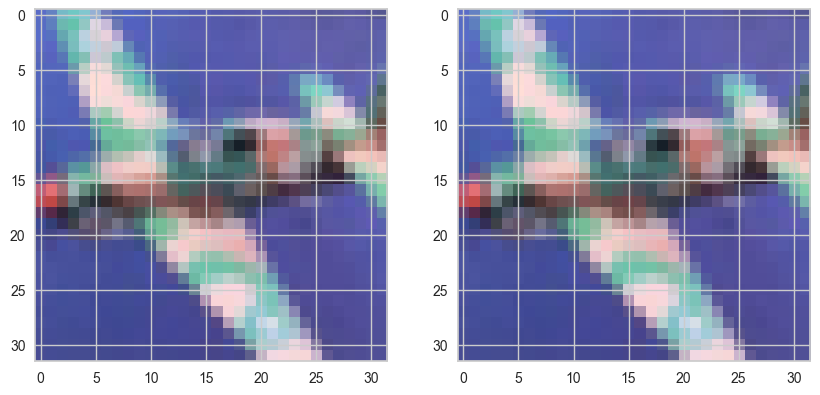

In [100]:
data1 = torchvision.datasets.CIFAR10(PATH_DATASETS, train=True, download=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
i = random.randint(0, NUM_TEST)
img_idx = int(re.findall(r'\d+', dataset_train_ssl[i][2])[-1])
axes[0].imshow(data1[img_idx][0])
axes[1].imshow(dataset_train_ssl[i][0])
for i in range(NUM_TRAIN):
    img_idx = int(re.findall(r'\d+', dataset_train_ssl[i][2])[-1])
    assert dataset_train_ssl[i][0] == data1[img_idx][0], i

In [101]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=True).fit_transform(
    features)

df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = X_embedded[:, 0]
df["comp-2"] = X_embedded[:, 1]

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.030s...
[t-SNE] Computed neighbors for 50000 samples in 10.796s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

[Text(0.5, 1.0, 'Iris data T-SNE projection')]

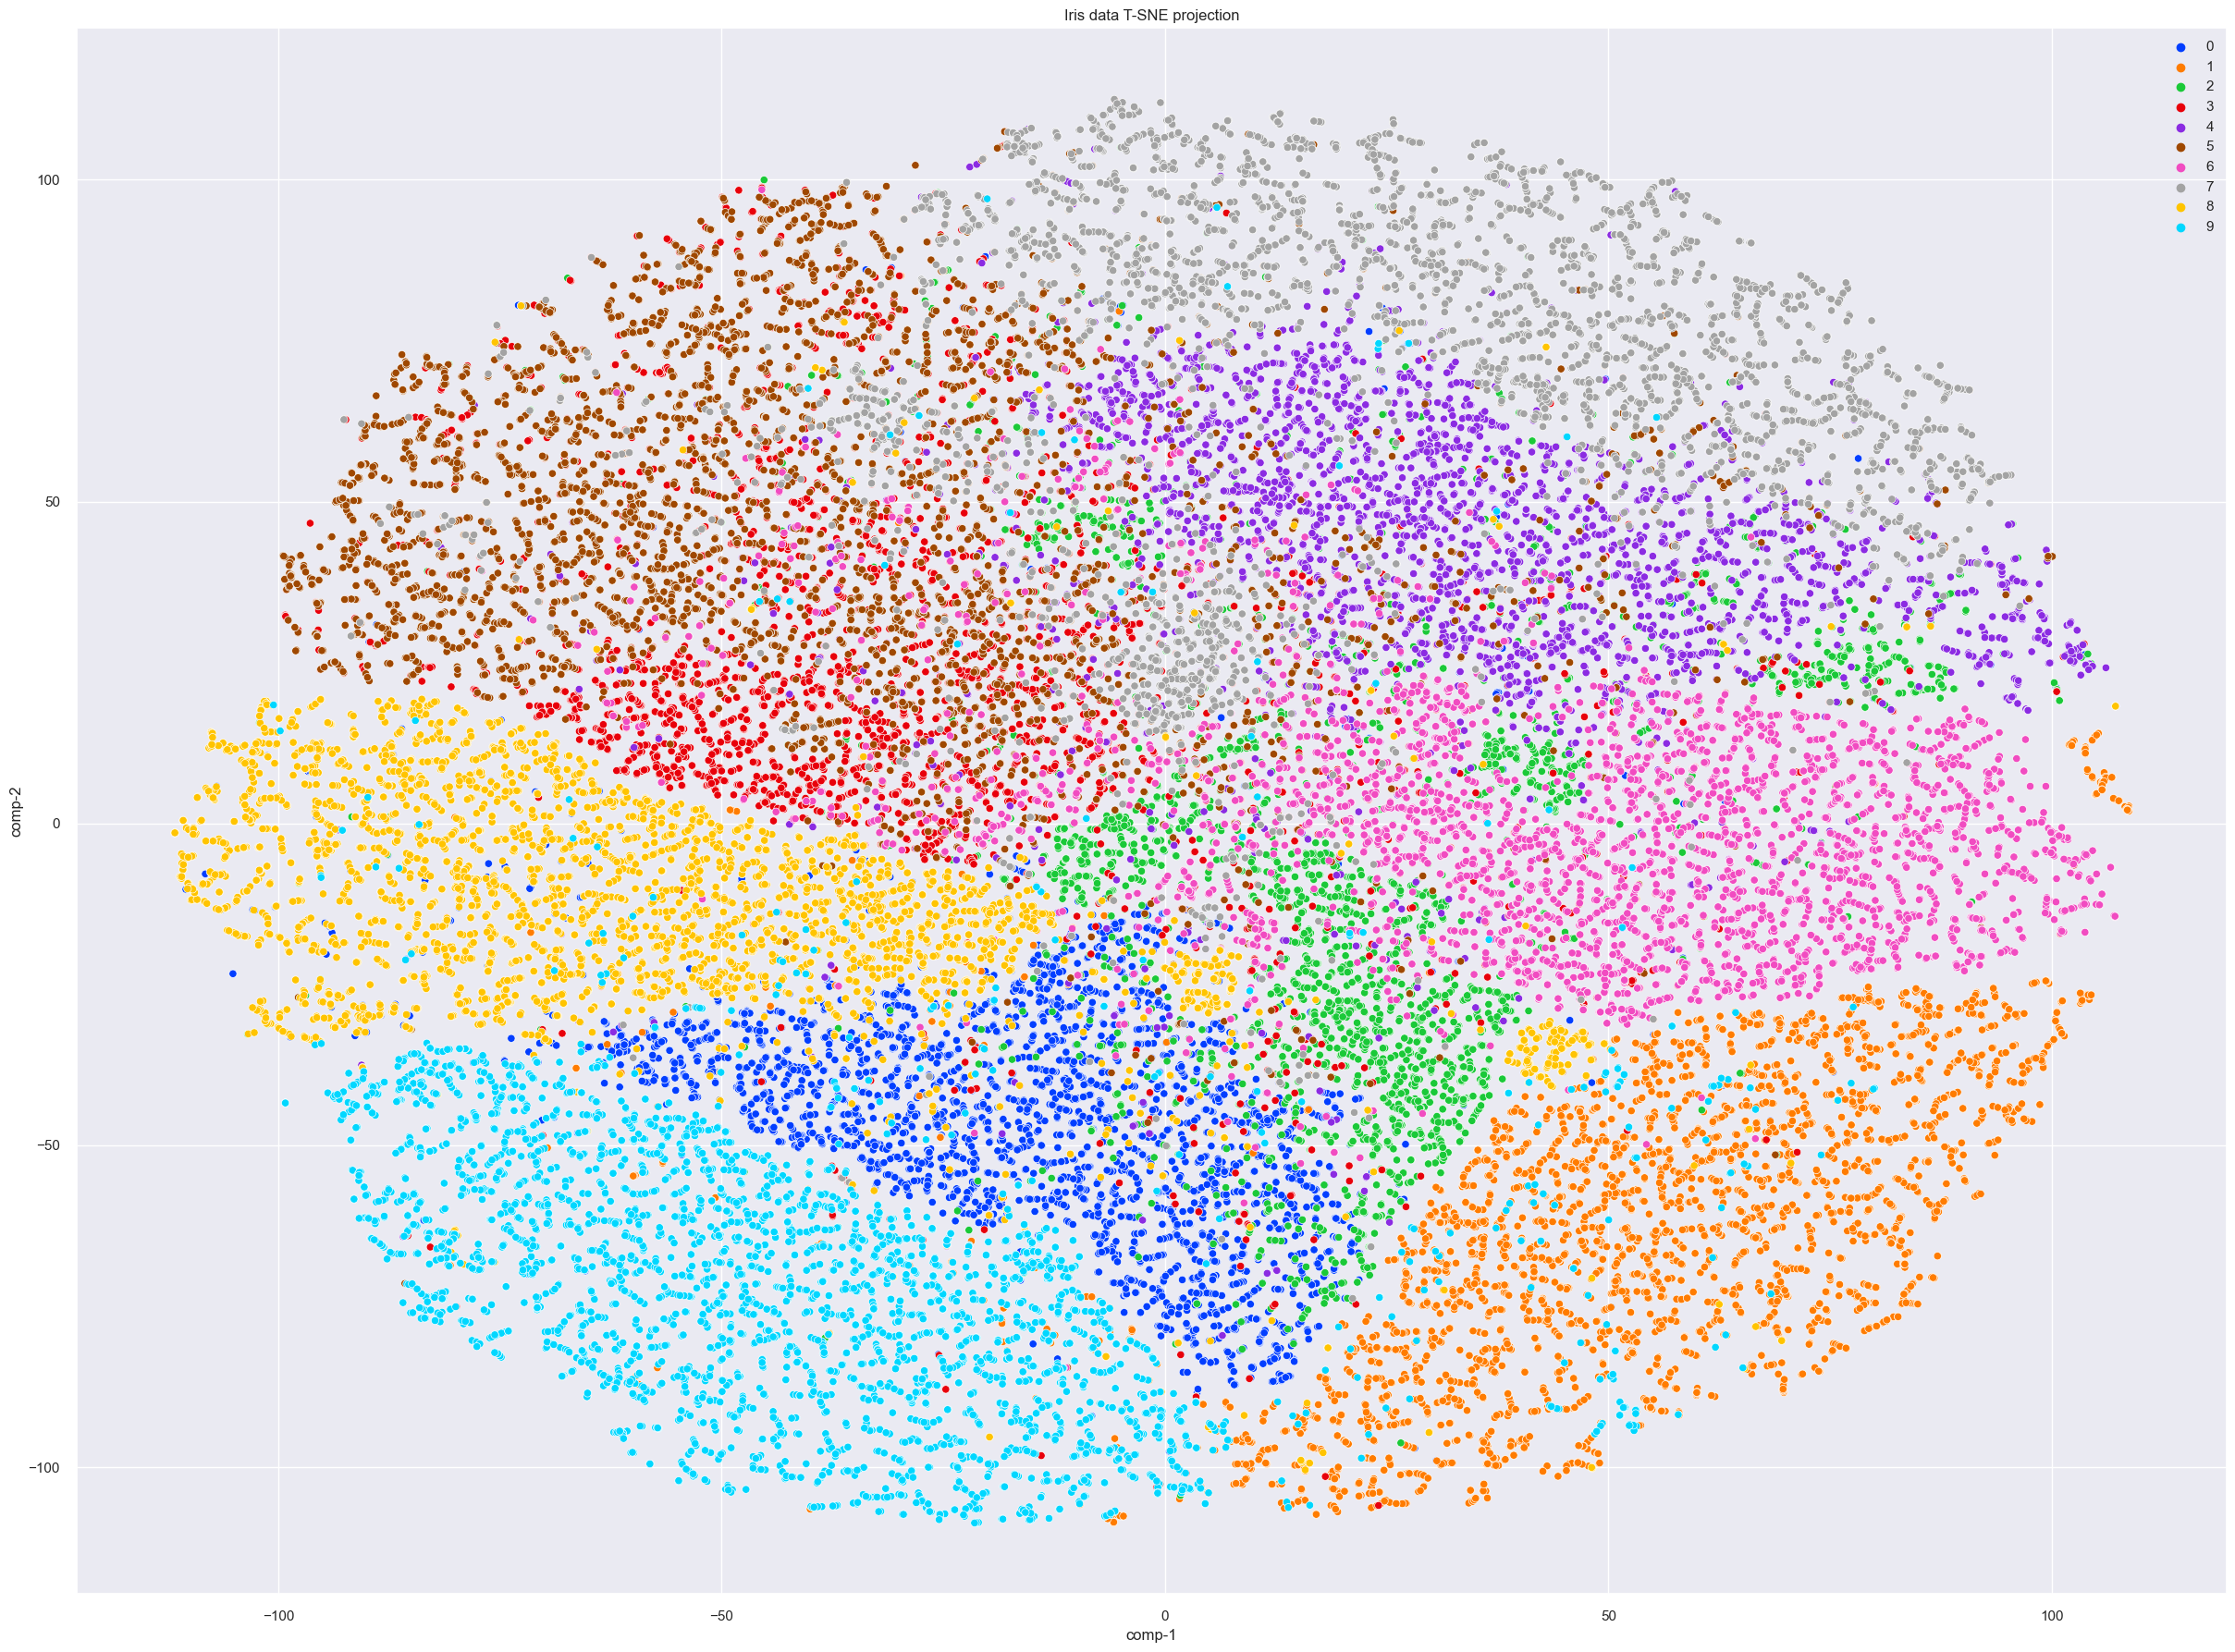

In [102]:
sns.set(rc={'figure.figsize': (30, 22)})
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("bright", 10),
                data=df).set(title="Iris data T-SNE projection")

In [85]:
clf = neighbors.KNeighborsClassifier(n_neighbors=200)
clf.fit(features, labels)
p = clf.predict(features)
sum(np.equal(p, labels)) / 50000

0.83362

In [73]:
features_test = np.empty((NUM_TEST, NUM_FEATURES))
labels_test = np.empty((NUM_TEST,), dtype=int)

n = 0
for images, label, files_names in dataloader_test:
    features_test[n:n + len(label)] = swav(images).detach().numpy()
    labels_test[n:(n := n + len(label))] = np.array(label)

sum(np.equal(clf.predict(features_test), labels_test)) / NUM_TEST

0.8269

In [104]:
idx = np.empty(NUM_TRAIN, dtype=int)
for i, img_data in enumerate(dataset_train_ssl):
    idx[int(re.findall(r'\d+', img_data[2])[-1])] = i
np.save(os.path.join(PATH_MODEL, 'idx.npy'), idx)

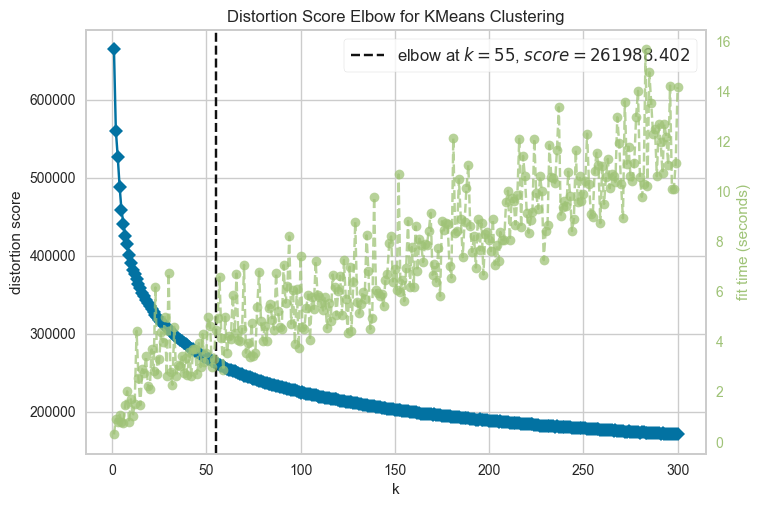

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [92]:
km = KMeans(max_iter=100000, n_init="auto", verbose=True)
visualizer = KElbowVisualizer(km, k=(1, 301))

visualizer.fit(features)  # Fit the data to the visualizer
visualizer.show()

In [105]:
k = 55
model_k_55 = KMeans(n_clusters=k, n_init="auto", max_iter=100000, verbose=True).fit(features)
pred_55 = model_k_55.predict(features)
m2_55 = model_k_55.transform(features)
km_dist = m2_55[np.arange(NUM_TRAIN), pred_55][idx]
np.save(os.path.join(PATH_MODEL, 'km_dist.npy'), km_dist)

Initialization complete
Iteration 0, inertia 392645.5842944926.
Iteration 1, inertia 281127.5704476051.
Iteration 2, inertia 274762.8252242152.
Iteration 3, inertia 271786.5706644777.
Iteration 4, inertia 269925.7516170118.
Iteration 5, inertia 268648.22665723914.
Iteration 6, inertia 267784.9337495563.
Iteration 7, inertia 267075.58179850085.
Iteration 8, inertia 266461.80043169187.
Iteration 9, inertia 265925.777763566.
Iteration 10, inertia 265519.1427965629.
Iteration 11, inertia 265191.2575097839.
Iteration 12, inertia 264922.8748039461.
Iteration 13, inertia 264660.2874447437.
Iteration 14, inertia 264420.2885742382.
Iteration 15, inertia 264207.74488299096.
Iteration 16, inertia 264011.3911851432.
Iteration 17, inertia 263835.24637761957.
Iteration 18, inertia 263676.68578803324.
Iteration 19, inertia 263545.91357201507.
Iteration 20, inertia 263441.1869803476.
Iteration 21, inertia 263363.1752797431.
Iteration 22, inertia 263300.4984634616.
Iteration 23, inertia 263242.31905636

In [106]:
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n_resnet18_cifar10', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar10', 'model', 'other.pt')

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
km_55 = np.load(os.path.join(PATH_MODEL, 'km_dist.npy'))

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_true_forget = true_forget.sort()[1].numpy()
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)
idx_sorted_km_55 = np.argsort(km_55)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'flip': idx_sorted_forgetting, 'forget': idx_true_forget,
              'km': idx_sorted_km_55}

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'flip': change_counter.numpy(),
    'forget': true_forget.numpy(),
    'km': km_55
})
data.corr()

EL2N       Std  True p sum      flip    forget        km
EL2N        1.000000  0.780107   -0.944299  0.658627  0.399751  0.519735
Std         0.780107  1.000000   -0.660269  0.586532  0.377763  0.488048
True p sum -0.944299 -0.660269    1.000000 -0.627331 -0.350162 -0.448969
flip        0.658627  0.586532   -0.627331  1.000000  0.770378  0.384439
forget      0.399751  0.377763   -0.350162  0.770378  1.000000  0.251247
km          0.519735  0.488048   -0.448969  0.384439  0.251247  1.000000

In [133]:
distortions = {}
inertias = {}
k_val = {}
K = range(1, 301)
for k in K:
    # Building and fitting the model
    print(f'------------   k={k}   --------------------------')
    kMeanModel = KMeans(n_clusters=k, max_iter=100000, n_init="auto", verbose=False).fit(features)

    pred = kMeanModel.predict(features)
    m2 = kMeanModel.transform(features)
    dist_ = m2[np.arange(NUM_TRAIN), pred]
    k_val[k] = dist_

    # i = random.randint(0, 50000)
    # print((np.sum(((features[i] - kMeanModel.cluster_centers_[pred[i]]) ** 2))) ** .5)
    # print(m2[i][pred[i]], dist_[i])

    dist = np.min(cdist(features, kMeanModel.cluster_centers_, 'euclidean'), axis=1)
    # print(dist[:2],dist_[:2])
    distortions[k] = np.average(dist)
    inertias[k] = kMeanModel.inertia_

with open(os.path.join(PATH_MODEL, 'all_k_1_300.npy'), 'wb') as f:
    pickle.dump([k_val, distortions, inertias], f)

------------   k=1   --------------------------
------------   k=2   --------------------------
------------   k=3   --------------------------
------------   k=4   --------------------------
------------   k=5   --------------------------
------------   k=6   --------------------------
------------   k=7   --------------------------
------------   k=8   --------------------------
------------   k=9   --------------------------
------------   k=10   --------------------------
------------   k=11   --------------------------
------------   k=12   --------------------------
------------   k=13   --------------------------
------------   k=14   --------------------------
------------   k=15   --------------------------
------------   k=16   --------------------------
------------   k=17   --------------------------
------------   k=18   --------------------------
------------   k=19   --------------------------
------------   k=20   --------------------------
------------   k=21   -------

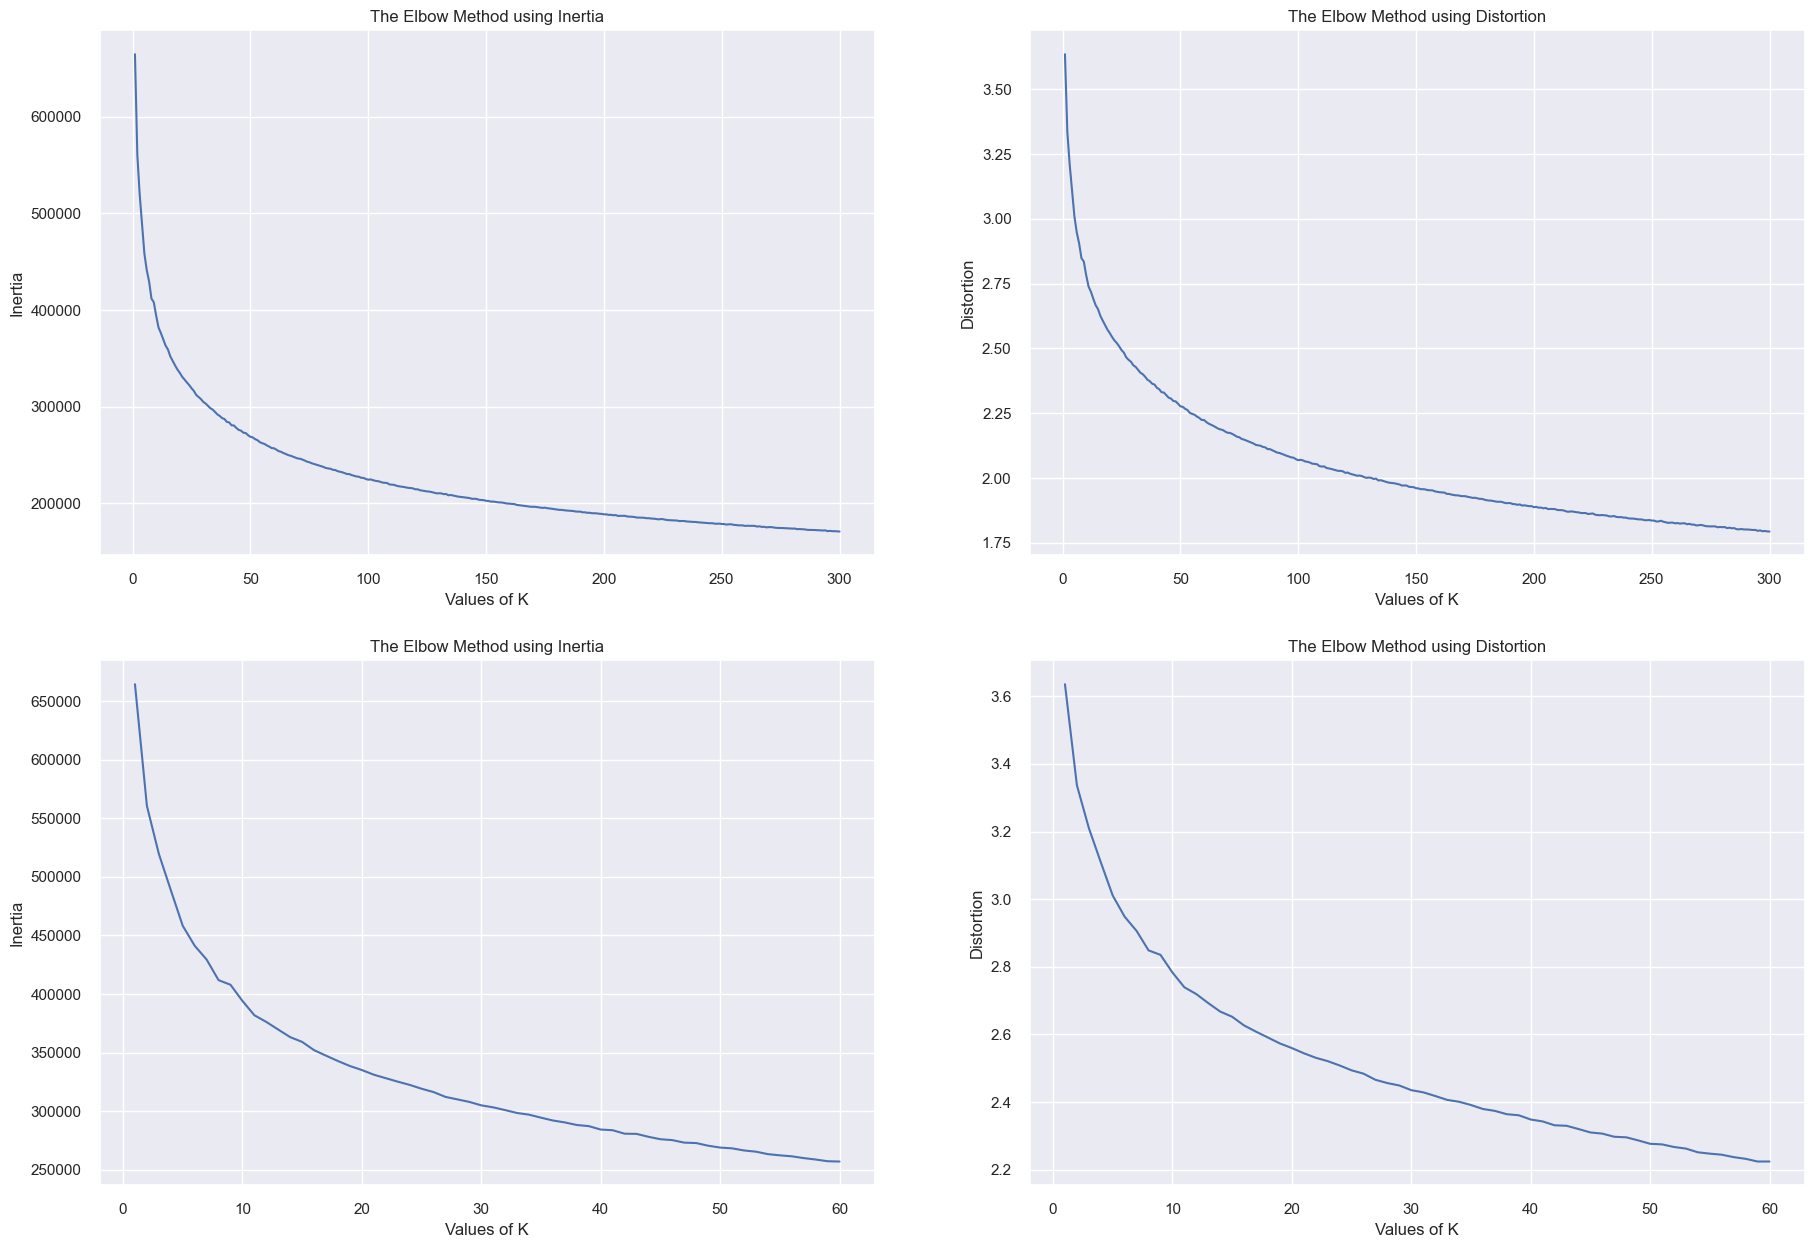

In [135]:
with open(os.path.join(PATH_MODEL, 'all_k_1_300.npy'), 'rb') as f:
    k_val, distortions, inertias = pickle.load(f)

plt.figure(figsize=(22, 15))
plt.subplot(2, 2, 1)
plt.plot([k for k in inertias.keys()], [k for k in inertias.values()], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

plt.subplot(2, 2, 2)
plt.plot([k for k in distortions.keys()], [k for k in distortions.values()], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')

plt.subplot(2, 2, 3)
plt.plot([k for k in inertias.keys()][:60], [k for k in inertias.values()][:60], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

plt.subplot(2, 2, 4)
plt.plot([k for k in distortions.keys()][:60], [k for k in distortions.values()][:60], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()